In [166]:
# import libraries
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from wordcloud import STOPWORDS,WordCloud
import gensim
from gensim.models import CoherenceModel
from gensim import corpora
import pandas as pd
import string, os, re
from textblob import TextBlob
import nltk
from nltk.stem import WordNetLemmatizer
from re import sub
from nltk.corpus import stopwords
from gensim import corpora, models
import pyLDAvis.gensim
from gensim.matutils import corpus2csc, sparse2full, corpus2dense
from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
import plotly.graph_objs as go
import plotly.offline as py
from sklearn.decomposition import NMF, LatentDirichletAllocation
from extract_dataframe import TweetDfExtractor
from extract_dataframe import read_json
from clean_tweets_dataframe import Clean_Tweets
import seaborn as sns

from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC 
from sklearn.naive_bayes import BernoulliNB 
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [15]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Data Extraction from the JSON file

In [4]:
_, tweet_list = read_json("data/global_twitter_data.json")
# _, tweet_list = read_json("data/sample.json")


In [5]:
tweet = TweetDfExtractor(tweet_list)

In [6]:
df_toStore = tweet.get_tweet_df(save=False)

In [10]:
df_toStore.to_pickle('cleaned_data.pkl')

In [103]:
#importing data 
df = pd.read_pickle('cleaned_data.pkl') 

## 2. Data Cleaning
- Clean the data using the script clean_tweets_dataframe


In [104]:
df.dtypes

created_at             object
source                 object
original_text          object
polarity              float64
subjectivity          float64
lang                   object
favorite_count          int64
retweet_count           int64
original_author        object
followers_count         int64
friends_count           int64
possibly_sensitive     object
hashtags               object
user_mentions          object
place                  object
dtype: object

In [105]:
df.shape

(22000, 15)

In [106]:
# the amount of duplicated entries

df.duplicated(subset='original_text', keep='first').sum()

14560

In [107]:
# import the cleaning class

clean_tweet = Clean_Tweets(df)

In [108]:
df = clean_tweet.drop_duplicate(df)

In [109]:
df.duplicated(subset='original_text', keep='first').sum()

0

In [110]:
# size of the remaining data
df.shape

(7440, 15)

In [111]:
# convert to datetime
df = clean_tweet.convert_to_datetime(df)

In [112]:
df.dtypes

created_at            datetime64[ns, UTC]
source                             object
original_text                      object
polarity                          float64
subjectivity                      float64
lang                               object
favorite_count                      int64
retweet_count                       int64
original_author                    object
followers_count                     int64
friends_count                       int64
possibly_sensitive                 object
hashtags                           object
user_mentions                      object
place                              object
dtype: object

## Data Preparation

##  3. Data Exploration

## Plots

<AxesSubplot:>

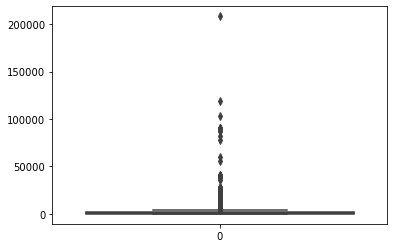

In [167]:
sns.boxplot(data = df['friends_count'])

<AxesSubplot:>

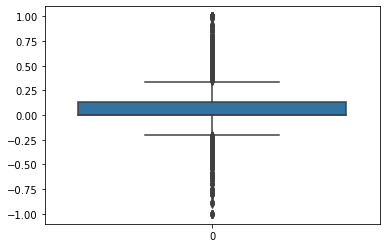

In [169]:
sns.boxplot(data = df['polarity'])

<AxesSubplot:>

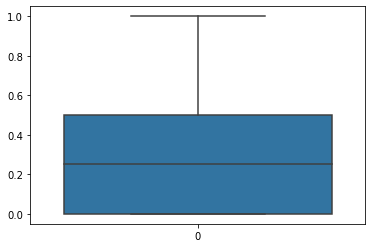

In [170]:
sns.boxplot(data = df['subjectivity'])

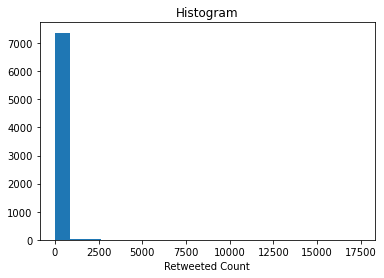

In [174]:
# This graph shows that, majority of tweets have no retweets
plt.hist(df['retweet_count'], bins=20)
plt.xlabel('Retweeted Count')
plt.title('Histogram')
plt.show()

In [26]:
# check if there's multiple language in the dataset
df.lang.unique()

array(['en'], dtype=object)

In [27]:
df.head()

,created_at,source,original_text,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place
0,2022-08-07 22:31:20+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @i_ameztoy: Extra random image (I):\n\nLets...,-1.250000e-01,0.190625,en,0,2,i_ameztoy,20497,2621,None,City,i_ameztoy,
1,2022-08-07 22:31:16+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @IndoPac_Info: #China's media explains the ...,-1.000000e-01,0.100000,en,0,201,ZIisq,65,272,None,"China, Taiwan",IndoPac_Info,
2,2022-08-07 22:31:07+00:00,"<a href=""http://twitter.com/download/android"" ...","China even cut off communication, they don't a...",0.000000e+00,0.000000,en,0,0,Fin21Free,85,392,None,XiJinping,ZelenskyyUa,Netherlands
3,2022-08-07 22:31:06+00:00,"<a href=""http://twitter.com/download/android"" ...","Putin to #XiJinping : I told you my friend, Ta...",1.000000e-01,0.350000,en,0,0,Fin21Free,85,392,None,XiJinping,,Netherlands
4,2022-08-07 22:31:04+00:00,"<a href=""http://twitter.com/download/iphone"" r...","RT @ChinaUncensored: I’m sorry, I thought Taiw...",-6.938894e-18,0.556250,en,0,381,VizziniDolores,910,2608,None,,ChinaUncensored,"Ayent, Schweiz"


In [28]:
df.tail()

,created_at,source,original_text,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place
21974,2022-08-06 18:04:28+00:00,"<a href=""https://mobile.twitter.com"" rel=""nofo...",RT @metesohtaoglu: 📌📸 Map of #China's possible...,0.000000,1.000000,en,0,3,PelosiLibArmy,8,128,None,"China, Taiwan",metesohtaoglu,"Seattle, WA"
21987,2022-08-06 18:03:58+00:00,"<a href=""http://twitter.com/download/iphone"" r...",RT @NEVERBOW: China is doing #exactly what #Ru...,0.250000,0.250000,en,0,1,SonnyMullins13,224,240,None,"exactly, Russia, Ukraine",NEVERBOW,
21989,2022-08-06 18:03:48+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Minister Wu is crystal clear in his @BBCNews i...,0.158333,0.419444,en,2,0,TECO_Toronto,955,202,False,"Taiwan, StandWithTaiwan, DefendDemocracy","BBCNews, SpeakerPelosi","Toronto, Canada"
21991,2022-08-06 18:03:46+00:00,"<a href=""http://twitter.com/download/android"" ...",Reports say that #China is planning to seize #...,0.000000,0.000000,en,0,0,samserjio93,22,59,None,"China, Taiwan",,
21997,2022-08-06 18:03:27+00:00,"<a href=""http://twitter.com/download/android"" ...",@Reuters Thanks #Pelosi smart move.,0.207143,0.421429,en,0,0,ZeitounRimal,88,0,None,Pelosi,Reuters,🇺🇲🇷🇺🇺🇦🇫🇷🇦🇪🇮🇱🏳️‍🌈


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7440 entries, 0 to 21997
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   created_at          7440 non-null   datetime64[ns, UTC]
 1   source              7440 non-null   object             
 2   original_text       7440 non-null   object             
 3   polarity            7440 non-null   float64            
 4   subjectivity        7440 non-null   float64            
 5   lang                7440 non-null   object             
 6   favorite_count      7440 non-null   int64              
 7   retweet_count       7440 non-null   int64              
 8   original_author     7440 non-null   object             
 9   followers_count     7440 non-null   int64              
 10  friends_count       7440 non-null   int64              
 11  possibly_sensitive  3977 non-null   object             
 12  hashtags            7440 non-null

In [30]:
# columns with a missing value is possibly_sensitive
print("The number of missing value(s): {}".format(df.isnull().sum().sum()))
print("Columons having columns value: {}".format(df.columns[df.isnull().any()]))

The number of missing value(s): 3463
Columons having columns value: Index(['possibly_sensitive'], dtype='object')


In [48]:
df.head()

,created_at,source,original_text,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place
0,2022-08-07 22:31:20+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @i_ameztoy: Extra random image (I):\n\nLets...,-1.250000e-01,0.190625,en,0,2,i_ameztoy,20497,2621,None,City,i_ameztoy,
1,2022-08-07 22:31:16+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @IndoPac_Info: #China's media explains the ...,-1.000000e-01,0.100000,en,0,201,ZIisq,65,272,None,"China, Taiwan",IndoPac_Info,
2,2022-08-07 22:31:07+00:00,"<a href=""http://twitter.com/download/android"" ...","China even cut off communication, they don't a...",0.000000e+00,0.000000,en,0,0,Fin21Free,85,392,None,XiJinping,ZelenskyyUa,Netherlands
3,2022-08-07 22:31:06+00:00,"<a href=""http://twitter.com/download/android"" ...","Putin to #XiJinping : I told you my friend, Ta...",1.000000e-01,0.350000,en,0,0,Fin21Free,85,392,None,XiJinping,,Netherlands
4,2022-08-07 22:31:04+00:00,"<a href=""http://twitter.com/download/iphone"" r...","RT @ChinaUncensored: I’m sorry, I thought Taiw...",-6.938894e-18,0.556250,en,0,381,VizziniDolores,910,2608,None,,ChinaUncensored,"Ayent, Schweiz"


In [49]:
# top 7 places
df.place.value_counts()[:7]

                              2805
Việt Nam                       116
India                          107
United States                   72
Turn on 🔔                       57
Hong Kong                       51
75-77 Malone Road, Belfast      43
Name: place, dtype: int64

In [50]:
# top 7 hashtags
df.hashtags.value_counts()[:7]

Taiwan            948
                  527
China, Taiwan     308
Taiwan, China     266
Pelosi            141
Pelosi, Taiwan    102
China              48
Name: hashtags, dtype: int64

In [51]:
# the result shows the tweet that has the maximum retweets
df.retweet_count.value_counts().index.max()

17409

In [52]:
# visualizing the dataset by sorting them using retweet count
df.sort_values(by='retweet_count', ascending=False)

,created_at,source,original_text,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place
7923,2022-08-07 13:06:53+00:00,"<a href=""http://twitter.com/download/android"" ...","RT @iingwen: Tonight, cities across #Taiwan 🇹🇼...",0.000000,0.000000,en,0,17409,TrumpThuan,350,4993,None,"Taiwan, StandWithUkraine",iingwen,Việt Nam
3228,2022-08-07 17:17:56+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @iingwen: A pleasure to meet with @SpeakerP...,0.216667,0.866667,en,0,9648,DorvalTony,4682,4806,None,Taiwan,"iingwen, SpeakerPelosi","Ottawa, Ontario"
8180,2022-08-07 12:55:49+00:00,"<a href=""https://about.twitter.com/products/tw...",RT @TeeNaHoo1: Taiwan is part of China ❌\nCOVI...,0.000000,0.000000,en,0,6714,milkmoonfive,1025,217,None,"ไต้หวัน, Taiwan",TeeNaHoo1,TREASURE / SEVENTEEN
955,2022-08-07 20:39:14+00:00,"<a href=""https://mobile.twitter.com"" rel=""nofo...",RT @Fallen_x_King: Scenes:\n#WWIII #Taiwan #WW...,0.000000,0.000000,en,0,6502,dr_sedd,203,197,False,"WWIII, Taiwan, WW3",Fallen_x_King,Hennessy in a TeaCup
2718,2022-08-07 17:55:22+00:00,"<a href=""https://mobile.twitter.com"" rel=""nofo...","RT @MOFA_Taiwan: Welcome to #Taiwan, @SpeakerP...",1.000000,0.900000,en,0,6299,BasqueCanada,32,102,None,Taiwan,"MOFA_Taiwan, SpeakerPelosi",Basque Canada
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5781,2022-08-07 14:57:07+00:00,"<a href=""https://mobile.twitter.com"" rel=""nofo...",We are stuck near a country who determines wha...,0.050000,0.200000,en,0,0,DhanukaDickwel1,34,456,None,"lka, srilankan, India, ChinaTaiwanCrisis, colo...",,
3157,2022-08-07 17:23:20+00:00,"<a href=""https://mobile.twitter.com"" rel=""nofo...",#Latest Footage of on-the-spot of #PLA’s drill...,0.250000,0.450000,en,0,0,vnzlasocial,286,684,False,"Latest, PLA, Taiwan",,
14621,2022-08-07 05:24:07+00:00,"<a href=""https://mobile.twitter.com"" rel=""nofo...",@RepMattGaetz Tell us why you have chosen Russ...,0.000000,0.000000,en,0,0,anthonysl5,75,475,None,"WW3, WWIII, WorldWar3, USA, Russia, Ukraine, N...","RepMattGaetz, NATO, UN","Portage, Indiana, USA"
14622,2022-08-07 05:24:04+00:00,"<a href=""https://mobile.twitter.com"" rel=""nofo...",The Eastern Theater Command of the Chinese Peo...,0.000000,0.000000,en,2,0,Beyea22764474,173,162,False,"PLA, Taiwan",,


In [53]:
# visualizing the dataset by sorting them using followers count
# we can deduce that twitter accounts with most followers in this account are in new delhi, or around india
df.sort_values(by='followers_count', ascending=False)

,created_at,source,original_text,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place
4542,2022-08-07 16:01:41+00:00,"<a href=""https://mobile.twitter.com"" rel=""nofo...",'Rehearsal for real operation': #China perform...,0.066667,0.266667,en,17,5,timesofindia,14498523,459,False,"China, Taiwan",,New Delhi
2715,2022-08-07 17:55:38+00:00,"<a href=""https://mobile.twitter.com"" rel=""nofo...",#Taiwan is not a part of #US but Chinese terri...,-0.041667,0.041667,en,33,3,timesofindia,14498522,459,False,"Taiwan, US",,New Delhi
8107,2022-08-07 13:00:01+00:00,"<a href=""https://studio.twitter.com"" rel=""nofo...",Day 3 of PLA's live-fire drills around #Taiwan...,0.000000,0.000000,en,65,26,CGTNOfficial,13298303,74,False,Taiwan,,"Beijing, China"
16235,2022-08-07 03:15:33+00:00,"<a href=""http://static.cms.xinhua-news.cn/sm/t...",Li Dazhao was a pioneer of the communist movem...,0.288889,0.411111,en,18,13,XHNews,12247593,74,False,XiJinping,,"Headquartered in Beijing, PRC"
3730,2022-08-07 16:47:00+00:00,"<a href=""https://about.twitter.com/products/tw...",#China keeps up pressure on #Taiwan with 4th d...,0.000000,0.000000,en,12,1,TimesNow,10249095,371,False,"China, Taiwan",,India
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21231,2022-08-06 18:58:22+00:00,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Should i upload this design on merch to sell ?...,0.000000,0.000000,en,0,0,Ziyaadkhan888,0,5,False,"winmetawin, Taiwan, TheSandman, yrkkh, ONEPIEC...",,
1420,2022-08-07 19:51:55+00:00,"<a href=""https://mobile.twitter.com"" rel=""nofo...",RT @Special_Offerr: ProDentim\nProprietary Ble...,0.000000,0.000000,en,0,891,IaraCar64423187,0,8,False,"dental, dentist, dentistry",Special_Offerr,
1397,2022-08-07 19:55:38+00:00,"<a href=""http://twitter.com/download/iphone"" r...",RT @TEMPEST450: AY THIS WAS AT MY SCHOOL DEAD ...,-0.200000,0.400000,en,0,3,b64684048,0,2,None,"Pelosi, helicopter, BlueJays, มากอดกันนะซีพฤกษ...",TEMPEST450,
1369,2022-08-07 19:58:50+00:00,"<a href=""https://mobile.twitter.com"" rel=""nofo...",RT @Apoooooo555: #Taiwan belongs to China❗️❗️❗...,0.000000,0.000000,en,0,246,Alfred59335294,0,2,False,Taiwan,Apoooooo555,


In [54]:
# the result shows the data collected on tweets that are made on two days
df['created_at'].dt.date.value_counts()

2022-08-07    6214
2022-08-06    1226
Name: created_at, dtype: int64

### Text Preprocessing

In [113]:
tweets = df['original_text']

In [114]:
tweets

0        RT @i_ameztoy: Extra random image (I):\n\nLets...
1        RT @IndoPac_Info: #China's media explains the ...
2        China even cut off communication, they don't a...
3        Putin to #XiJinping : I told you my friend, Ta...
4        RT @ChinaUncensored: I’m sorry, I thought Taiw...
                               ...                        
21974    RT @metesohtaoglu: 📌📸 Map of #China's possible...
21987    RT @NEVERBOW: China is doing #exactly what #Ru...
21989    Minister Wu is crystal clear in his @BBCNews i...
21991    Reports say that #China is planning to seize #...
21997                  @Reuters Thanks #Pelosi smart move.
Name: original_text, Length: 7440, dtype: object

In [115]:
# remove characters and non-english letters
tweets = tweets.str.replace('[^a-zA-Z]', ' ')

In [116]:
# Remove the stop words to prepare the word clouds
stopWords = set(STOPWORDS)
stopWords.update(["rt","https","will","the"])

tweets = tweets.apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stopWords))

In [117]:
tweets

0        rt ameztoy extra random image i lets focus one...
1        rt indopac info china s media explains militar...
2        china even cut communication don t anwer phone...
3        putin xijinping i told friend taiwan vassal st...
4        rt chinauncensored i m sorry i thought taiwan ...
                               ...                        
21974    rt metesohtaoglu map china s possible trade bl...
21987    rt neverbow china exactly russia ukraine biden...
21989    minister wu crystal clear bbcnews interview sp...
21991    reports say china planning seize taiwan hour a...
21997                     reuters thanks pelosi smart move
Name: original_text, Length: 7440, dtype: object

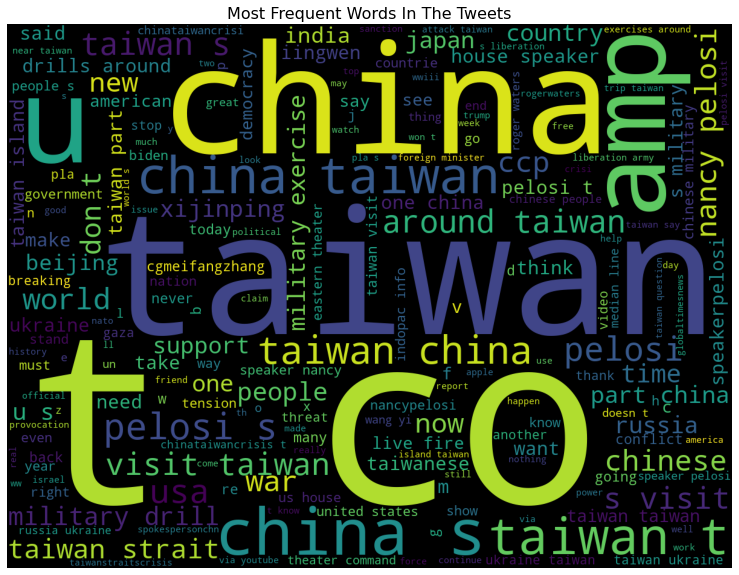

In [118]:
# word cloud of the most frequent words
plt.figure(figsize=(20, 10))
plt.imshow(WordCloud(width=1200,height=900,stopwords=stopWords).generate(' '.join(tweets.values)))
plt.axis('off')
plt.title('Most Frequent Words In The Tweets',fontsize=16)
plt.show()

In [119]:
# plot of top and bottom 50 words

all_words = tweets.str.split(
    expand=True).unstack().value_counts()
x = [r for r in all_words.index.values if len(r) > 1]
y = all_words.values
data = [go.Bar(
    x=x[2:50],
    y=y[2:50],
    marker=dict(colorscale='Jet',
                color=y[2:100]
                ),
    text='Word counts'
)]

layout = go.Layout(
    title='Top 50 (Uncleaned) Word frequencies in the Original dataset'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')


data = [go.Bar(
    x=x[-100:],
    y=y[-100:],
    marker=dict(colorscale='Portland',
                color=y[-100:]
                ),
    text='Word counts'
)]

layout = go.Layout(
    title='Bottom 100 Word frequencies before Preprocessing'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')


In [120]:
# Transforming the words using CountVectorizer for further processing
vectorizer = CountVectorizer(min_df=2,max_df=0.95,stop_words=stopWords)
Transformed_tweets= vectorizer.fit_transform(tweets)

## Cleaning Dataset and Lemmatization

In [121]:
# Functions for data cleaning
wnl = WordNetLemmatizer()


def lemmatize(myWord):
    """Function to lemmatize words"""
    if myWord is None:
        return myWord
    else:
        return str(wnl.lemmatize(myWord))


def removeStopWords(myWord):
    """Function to remove stop words"""
    if myWord is None:
        return myWord
    if myWord not in str(stopWords):
        return myWord


def removeLinkUser(myWord):
    """Function to remove web addresses and twitter handles"""
    if not myWord.startswith('@') and not myWord.startswith('http'):
        return myWord


def prepText(myWord):
    """Final text pre-processing function"""
    return removeStopWords(
        lemmatize(

            removeLinkUser(
                myWord.lower()
            )
        )
    )
def filterTweetList(tweetList):
    """Remove stop words, lemmatize, and clean all tweets"""
    return [[prepText(word) for word
                in tweet.split()
                    if prepText(word) is not None]
                for tweet in tweetList]

In [122]:
# applying the cleaning function

Clean_TweetsList = filterTweetList(tweets)

# Topic Modelling

### 1. LDA Model

In [123]:
# Application of LDA in machine learning - specifically, topic discovery is mostly known 
# since the Tweeter dataset consists of many different messages applying this method can be helpful
# most of the codes are imported from http://frickp.github.io/lda-airline-visualization.html

In [124]:
def makeDict(myTweetList):
    """Create dictionary from list of tokenized documents"""
    return corpora.Dictionary(myTweetList)

def makeCorpus(myTweetList,myDict):
    """Create corpus from list of tokenized documents"""
    return [myDict.doc2bow(tweet) for tweet in myTweetList]

def createLDA(myCorpus, myDictionary,myTopics=50,myPasses=10,myIterations=50,myAlpha=0.001):
    """LDA model call function"""
    return models.LdaMulticore(myCorpus, id2word=myDictionary, num_topics=myTopics, passes=myPasses,
    iterations=myIterations,alpha=myAlpha)

In [125]:
#"""Create model objects"""
kagDict   = makeDict(Clean_TweetsList)
kagCorpus = makeCorpus(Clean_TweetsList, kagDict)
kagLda = createLDA(kagCorpus, kagDict)

In [81]:
# this plot shows different topics learned by the LDA model, but the plots show inconsistent result 

ldaViz

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
32     0.225303 -0.111798       1        1  6.830397
4      0.086718  0.045528       2        1  3.535028
48     0.157592 -0.156045       3        1  3.492609
27     0.083293  0.051954       4        1  3.359413
15     0.053328  0.066446       5        1  3.280341
29     0.107638 -0.003482       6        1  3.230877
46     0.127429 -0.023198       7        1  3.173447
9     -0.052132 -0.029336       8        1  2.720575
42     0.051178  0.048713       9        1  2.598432
34     0.052063  0.010339      10        1  2.592237
14     0.061394  0.076728      11        1  2.540536
16     0.004505  0.019842      12        1  2.479368
8      0.038401  0.082554      13        1  2.471776
12     0.030697  0.037267      14        1  2.375398
13     0.009032  0.047499      15        1  2.342652
3     -0.010320  0.063863      16        1  2.188447
22     0.034082  0.027604      17        1  2.140446
37    -0.004100  0.016975      18        1  2.110674
35     0.041953  0.006638      19        1  2.081087
44     0.011678  0.046595      20        1  2.071361
33     0.098252 -0.108963      21        1  2.064170
6      0.012195  0.064988      22        1  2.045099
25     0.027845 -0.005970      23        1  2.019195
21     0.014290  0.057092      24        1  1.960314
39    -0.007150  0.062674      25        1  1.853493
11    -0.021836  0.080537      26        1  1.830236
43    -0.006578  0.031554      27        1  1.776809
19     0.003202 -0.031890      28        1  1.763185
40     0.009771 -0.001506      29        1  1.761041
2     -0.010984 -0.002324      30        1  1.675661
45     0.015359 -0.018269      31        1  1.606714
23    -0.019726  0.031564      32        1  1.579433
18    -0.037840  0.036070      33        1  1.531765
10    -0.098575 -0.039985      34        1  1.512537
49    -0.055558  0.018927      35        1  1.493326
28    -0.027872  0.006624      36        1  1.437748
38    -0.009950 -0.055409      37        1  1.383834
20    -0.101241 -0.125680      38        1  1.284627
1     -0.020195 -0.015034      39        1  1.268254
24     0.023700 -0.048744      40        1  1.257095
26    -0.109247  0.005256      41        1  1.135991
36    -0.068910 -0.018899      42        1  1.090991
0     -0.116474 -0.043335      43        1  0.992353
41    -0.028718 -0.020811      44        1  0.991841
47    -0.104143  0.003900      45        1  0.943059
31    -0.100226 -0.044770      46        1  0.936710
7     -0.067921 -0.013762      47        1  0.893971
30    -0.086836 -0.009178      48        1  0.892088
17    -0.103525 -0.048168      49        1  0.810168
5     -0.110841 -0.071175      50        1  0.593190, topic_info=          Term         Freq        Total Category  logprob  loglift
505   exercise   396.000000   396.000000  Default  30.0000  30.0000
51      pelosi  1345.000000  1345.000000  Default  29.0000  29.0000
18       drill   477.000000   477.000000  Default  28.0000  28.0000
120        pla   320.000000   320.000000  Default  27.0000  27.0000
24    military   777.000000   777.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
1658      trip     2.023501   109.626723  Topic50  -5.8835   1.1352
9          one     2.000202   290.753292  Topic50  -5.8950   0.1482
72           z     1.904678    89.813318  Topic50  -5.9440   1.2740
246        day     1.913177   263.544714  Topic50  -5.9395   0.2020
1335      free     1.896394    78.068072  Topic50  -5.9483   1.4098

[3418 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
11756     16  0.489534       aanhpi
11756     34  0.163178       aanhpi
1985       6  0.864176  aariannewsx
2624       5  0.045865          abc
2624       9  0.091730          abc
...      ...       ...          ...
18174     10  0.910627        zujci
12027     47  0.644434 

In [82]:
lda = LatentDirichletAllocation(n_components=11, max_iter=5,
                                learning_method = 'online',
                                learning_offset = 50.,
                                random_state = 0)

In [85]:
##
lda.fit(Transformed_tweets)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, n_components=11, random_state=0)

In [86]:
# Define helper function to print top words
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = "\nTopic #{}:\n".format(index)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
        print(message)
        print("="*70)

In [87]:
n_top_words = 40
print("\nTopics in LDA model: ")
tf_feature_names = vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)


Topics in LDA model: 

Topic #0:
gt pakistan music defend cut let li love tai trending smart tsai israel good cheating cyber peace wen weekend join better men coas trend sunday ing hsing group completed enjoy russia korea georgegalloway liz measures uae nicaragua ukraine mranteater civilians

Topic #1:
week co women taiwan click lisa anjaliarora bb hackers alexberjuang beautiful hacked saw tv several channels costly song occupation beauty leopard terrorist isolate twitter camera nsfwtw svg health fat osint plus diplomat top pa barbaric trades maker patriotic threatened establishment

Topic #2:
taiwan china co chinese military drills around pla island taiwanese exercises attack chinataiwancrisis strait live amp taipei army us air joint breaking day said fire aircraft beijing defense missile taiwanstraitscrisis missiles war ccp near ministry warships taiwanchina news eastern end

Topic #3:
xi seen speech daily jinping hawaii fashion onechinapolicy explains front domestic declared rondes

In [88]:
first_topic = lda.components_[0]
second_topic = lda.components_[1]
third_topic = lda.components_[2]
fourth_topic = lda.components_[3]

In [89]:
## WordCloud Visualisations for the topics

In [90]:
first_topic_words = [tf_feature_names[i] for i in first_topic.argsort()[:-50 - 1 :-1]]
second_topic_words = [tf_feature_names[i] for i in second_topic.argsort()[:-50 - 1 :-1]]
third_topic_words = [tf_feature_names[i] for i in third_topic.argsort()[:-50 - 1 :-1]]
fourth_topic_words = [tf_feature_names[i] for i in fourth_topic.argsort()[:-50 - 1 :-1]]

In [91]:
def plot_WordClouds(topic_words,name):
    print(name + " cloud Plot: \n")
    # Generating the wordcloud with the values under the category dataframe
    cloud = WordCloud(
                              stopwords=stopWords,
                              background_color='black',
                              width=4500,
                              height=2800
                             ).generate(" ".join(topic_words))
    plt.imshow(cloud)
    plt.axis('off')
    plt.show()
    print("\n\n")

first cloud Plot: 



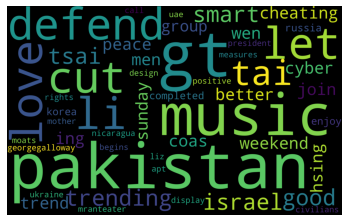




second cloud Plot: 



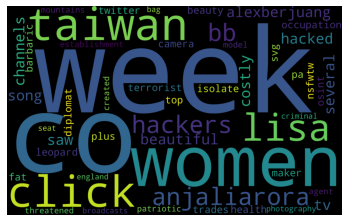




third cloud Plot: 



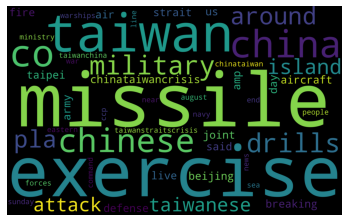




fourth cloud Plot: 



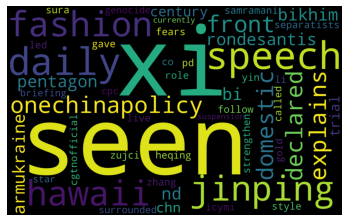

In [92]:
plot_WordClouds(first_topic_words,'first')
plot_WordClouds(second_topic_words,'second')
plot_WordClouds(third_topic_words,'third')
plot_WordClouds(fourth_topic_words,'fourth')

# Sentiment Analysis

In [126]:
#Converting tweets to list of words For feature engineering
sentence_list = [tweet for tweet in tweets]
word_list = [sent.split() for sent in sentence_list]

In [127]:
# showing the list of words
print('\nPlain Sentence: ' + tweets.values[0] + '\n')
print('Generated List: \n'+ str(word_list[:1]))
print('')


Plain Sentence: rt ameztoy extra random image i lets focus one specific zone western coast gt longjing district taichung city ta

Generated List: 
[['rt', 'ameztoy', 'extra', 'random', 'image', 'i', 'lets', 'focus', 'one', 'specific', 'zone', 'western', 'coast', 'gt', 'longjing', 'district', 'taichung', 'city', 'ta']]



In [128]:
def text_category(p):
    v = TextBlob(p).sentiment.polarity
    if v > 0:
        return 'positive'
    elif v < 0:
        return 'negative'
    else:
        return 'neutral'
        


In [131]:
df['polarity']

0       -1.250000e-01
1       -1.000000e-01
2        0.000000e+00
3        1.000000e-01
4       -6.938894e-18
             ...     
21974    0.000000e+00
21987    2.500000e-01
21989    1.583333e-01
21991    0.000000e+00
21997    2.071429e-01
Name: polarity, Length: 7440, dtype: float64

In [130]:
df['pscore'] = df.original_text.apply(text_category)

In [132]:
df[['original_text','pscore','polarity']]

,original_text,pscore,polarity
0,RT @i_ameztoy: Extra random image (I):\n\nLets...,negative,-1.250000e-01
1,RT @IndoPac_Info: #China's media explains the ...,negative,-1.000000e-01
2,"China even cut off communication, they don't a...",neutral,0.000000e+00
3,"Putin to #XiJinping : I told you my friend, Ta...",positive,1.000000e-01
4,"RT @ChinaUncensored: I’m sorry, I thought Taiw...",negative,-6.938894e-18
...,...,...,...
21974,RT @metesohtaoglu: 📌📸 Map of #China's possible...,neutral,0.000000e+00
21987,RT @NEVERBOW: China is doing #exactly what #Ru...,positive,2.500000e-01
21989,Minister Wu is crystal clear in his @BBCNews i...,positive,1.583333e-01
21991,Reports say that #China is planning to seize #...,neutral,0.000000e+00


In [133]:
# CleanTweet['pscore'].value_count()
df.pscore.value_counts()

neutral     2894
positive    2768
negative    1778
Name: pscore, dtype: int64

<AxesSubplot:>

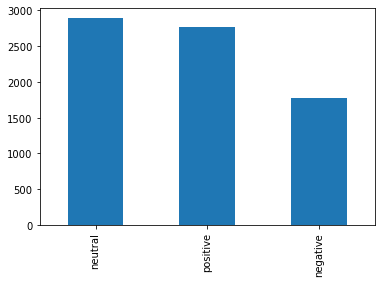

In [135]:
df['pscore'].value_counts().plot.bar()

In [136]:
Clean_Data = df[df['pscore']!='neutral']

In [138]:
def norm(d):
    if d>0:
        return 1
    else: 
        return 0

In [139]:
Clean_Data['scoremap'] = Clean_Data['polarity'].apply(norm)

In [140]:
from sklearn.model_selection import train_test_split
import numpy as np


In [141]:
y = Clean_Data['scoremap'].values
X = Clean_Data['original_text']

In [142]:
X_train, X_test, y_train, y_test =train_test_split(X, y,test_size=0.4,random_state=0)

In [143]:
# unigram and bigram

bigram_vectorizer = CountVectorizer(ngram_range=(1, 2))
bigram_vectorizer.fit(X.values)

trigram_vectorizer = CountVectorizer(ngram_range=(1, 3))
trigram_vectorizer.fit(X.values)

X_train_bigram = bigram_vectorizer.transform(X_train)
X_train_trigram = trigram_vectorizer.transform(X_train)

In [144]:
trigram_vectorizer.vocabulary_


{'rt': 110547,
 'i_ameztoy': 63812,
 'extra': 46933,
 'random': 106158,
 'image': 64680,
 'lets': 77783,
 'focus': 49408,
 'in': 65040,
 'one': 95212,
 'very': 147753,
 'specific': 120529,
 'zone': 159876,
 'of': 91484,
 'the': 130947,
 'western': 152238,
 'coast': 33040,
 'gt': 55860,
 'longjing': 79385,
 'district': 41014,
 'taichung': 124483,
 'city': 29021,
 'ta': 124411,
 'rt i_ameztoy': 111387,
 'i_ameztoy extra': 63813,
 'extra random': 46942,
 'random image': 106159,
 'image lets': 64689,
 'lets focus': 77786,
 'focus in': 49409,
 'in one': 65846,
 'one very': 95388,
 'very specific': 147860,
 'specific zone': 120530,
 'zone of': 159887,
 'of the': 93116,
 'the western': 134952,
 'western coast': 152246,
 'coast gt': 33047,
 'gt longjing': 55882,
 'longjing district': 79386,
 'district taichung': 41019,
 'taichung city': 124486,
 'city ta': 29048,
 'rt i_ameztoy extra': 111388,
 'i_ameztoy extra random': 63814,
 'extra random image': 46943,
 'random image lets': 106160,
 'image

In [145]:
bigram_vectorizer.vocabulary_


{'rt': 54768,
 'i_ameztoy': 31865,
 'extra': 24654,
 'random': 52404,
 'image': 32285,
 'lets': 38462,
 'focus': 26019,
 'in': 32496,
 'one': 46754,
 'very': 71312,
 'specific': 59763,
 'zone': 76915,
 'of': 45433,
 'the': 64337,
 'western': 73400,
 'coast': 17214,
 'gt': 29164,
 'longjing': 39271,
 'district': 21525,
 'taichung': 61896,
 'city': 14137,
 'ta': 61852,
 'rt i_ameztoy': 55127,
 'i_ameztoy extra': 31866,
 'extra random': 24660,
 'random image': 52405,
 'image lets': 32290,
 'lets focus': 38464,
 'focus in': 26020,
 'in one': 32792,
 'one very': 46826,
 'very specific': 71362,
 'specific zone': 59764,
 'zone of': 76921,
 'of the': 46018,
 'the western': 65685,
 'western coast': 73404,
 'coast gt': 17218,
 'gt longjing': 29173,
 'longjing district': 39272,
 'district taichung': 21528,
 'taichung city': 61898,
 'city ta': 14150,
 'indopac_info': 33345,
 'china': 12668,
 'media': 40807,
 'explains': 24539,
 'military': 41307,
 'reasons': 52863,
 'for': 26159,
 'each': 22550,
 

## Tf-IDF

In [146]:
bigram_tf_idf_transformer = TfidfTransformer()
bigram_tf_idf_transformer.fit(X_train_bigram)
X_train_bigram_tf_idf = bigram_tf_idf_transformer.transform(X_train_bigram)

trigram_tf_idf_transformer = TfidfTransformer()
trigram_tf_idf_transformer.fit(X_train_trigram)
X_train_trigram_tf_idf = trigram_tf_idf_transformer.transform(X_train_trigram)


In [147]:
def train_and_show_scores(X, y: np.array, title: str) -> None:
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, train_size=0.8, stratify=y
    )

    clf = SGDClassifier()
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    valid_score = clf.score(X_valid, y_valid)
    print(f'{title}\nTrain score: {round(train_score, 2)} ; Validation score: {round(valid_score, 2)}\n')

In [148]:

# X_train_trigram = df
train_and_show_scores(X_train_trigram, y_train, 'Trigram Counts')
train_and_show_scores(X_train_trigram_tf_idf, y_train, 'Trigram Tf-IDF')

train_and_show_scores(X_train_bigram, y_train, 'Bigram Counts')
train_and_show_scores(X_train_bigram_tf_idf, y_train, 'Bigram TF-IDF')


Trigram Counts
Train score: 1.0 ; Validation score: 0.79

Trigram Tf-IDF
Train score: 1.0 ; Validation score: 0.79

Bigram Counts
Train score: 1.0 ; Validation score: 0.77

Bigram TF-IDF
Train score: 1.0 ; Validation score: 0.78



In [155]:
KNN_Classifier = KNeighborsClassifier(n_jobs=-1)
LGR_Classifier = LogisticRegression(n_jobs=-1, random_state=0)
BNB_Classifier = BernoulliNB()
DT_Classifier = tree.DecisionTreeClassifier(criterion='entropy', random_state=0)
RF_Classifier = RandomForestClassifier(criterion='entropy', n_jobs=-1, random_state=0)
SVM_Classifier = SVC(random_state=0)





In [156]:

def evaluation(X_data,y_data):
    x_train, x_valid, y_train, y_valid = train_test_split(
        X_data, y_data, train_size=0.7
    )
    model_list = []


    model_list.append(('SVM Classifier',SVM_Classifier))
    model_list.append(('Naive Baye Classifier', BNB_Classifier))
    model_list.append(('Decision Tree Classifier', DT_Classifier))
    model_list.append(('RandomForest Classifier', RF_Classifier))
    model_list.append(('KNeighborsClassifier', KNN_Classifier))
    model_list.append(('LogisticRegression', LGR_Classifier))


    for i, v in model_list:
        
        v.fit(X=x_train,y= y_train)
        scores = cross_val_score(v, x_valid, y_valid, cv=10)
        accuracy = metrics.accuracy_score(y_valid, v.predict(x_valid))
        confusion_matrix = metrics.confusion_matrix(y_valid, v.predict(x_valid))
        classification = metrics.classification_report(y_valid, v.predict(x_valid),zero_division= 0)

        print()

        print('=============================={}  Model Evaluation =============================='.format(i))
        
        print()

        print ("Cross Validation Mean Score:" "\n", scores.mean())

        print()

        print ("Model Accuracy:" "\n", accuracy)

        print()

        



In [157]:
# Bigram vectorization
evaluation(X_data = X_train_bigram,y_data = y_train)


==============================SVM Classifier  Model Evaluation ==============================

Cross Validation Mean Score:
 0.6727943390545017

Model Accuracy:
 0.7094017094017094


==============================Naive Baye Classifier  Model Evaluation ==============================

Cross Validation Mean Score:
 0.5836344474555857

Model Accuracy:
 0.6117216117216118


==============================Decision Tree Classifier  Model Evaluation ==============================

Cross Validation Mean Score:
 0.6838000602228245

Model Accuracy:
 0.7655677655677655


==============================RandomForest Classifier  Model Evaluation ==============================

Cross Validation Mean Score:
 0.666651610960554

Model Accuracy:
 0.7264957264957265


==============================KNeighborsClassifier  Model Evaluation ==============================

Cross Validation Mean Score:
 0.6325052694971394

Model Accuracy:
 0.6373626373626373


==============================LogisticRegression  Mod

In [158]:
# Trigram vectorization
evaluation(X_data = X_train_trigram,y_data = y_train)


==============================SVM Classifier  Model Evaluation ==============================

Cross Validation Mean Score:
 0.6545016561276723

Model Accuracy:
 0.7326007326007326


==============================Naive Baye Classifier  Model Evaluation ==============================

Cross Validation Mean Score:
 0.6251580849141825

Model Accuracy:
 0.6398046398046398


==============================Decision Tree Classifier  Model Evaluation ==============================

Cross Validation Mean Score:
 0.6654170430593196

Model Accuracy:
 0.7557997557997558


==============================RandomForest Classifier  Model Evaluation ==============================

Cross Validation Mean Score:
 0.6703402589581452

Model Accuracy:
 0.7582417582417582


==============================KNeighborsClassifier  Model Evaluation ==============================

Cross Validation Mean Score:
 0.6275820535983138

Model Accuracy:
 0.6666666666666666


==============================LogisticRegression  Mo

In [159]:
# Bigram Tf-IDF vectorization
evaluation(X_data = X_train_bigram_tf_idf,y_data = y_train)


==============================SVM Classifier  Model Evaluation ==============================

Cross Validation Mean Score:
 0.6483589280337249

Model Accuracy:
 0.7094017094017094


==============================Naive Baye Classifier  Model Evaluation ==============================

Cross Validation Mean Score:
 0.5970641373080398

Model Accuracy:
 0.6349206349206349


==============================Decision Tree Classifier  Model Evaluation ==============================

Cross Validation Mean Score:
 0.6678259560373381

Model Accuracy:
 0.7203907203907204


==============================RandomForest Classifier  Model Evaluation ==============================

Cross Validation Mean Score:
 0.6764679313459802

Model Accuracy:
 0.7338217338217338


==============================KNeighborsClassifier  Model Evaluation ==============================

Cross Validation Mean Score:
 0.6386781090033122

Model Accuracy:
 0.6923076923076923


==============================LogisticRegression  Mo

In [160]:
# Trigram Tf-IDF vectorization
evaluation(X_data = X_train_trigram_tf_idf,y_data = y_train)


==============================SVM Classifier  Model Evaluation ==============================

Cross Validation Mean Score:
 0.630051189400783

Model Accuracy:
 0.7032967032967034


==============================Naive Baye Classifier  Model Evaluation ==============================

Cross Validation Mean Score:
 0.5970641373080398

Model Accuracy:
 0.6288156288156288


==============================Decision Tree Classifier  Model Evaluation ==============================

Cross Validation Mean Score:
 0.6628124059018369

Model Accuracy:
 0.7106227106227107


==============================RandomForest Classifier  Model Evaluation ==============================

Cross Validation Mean Score:
 0.655736224028907

Model Accuracy:
 0.717948717948718


==============================KNeighborsClassifier  Model Evaluation ==============================

Cross Validation Mean Score:
 0.6507527853056307

Model Accuracy:
 0.673992673992674


==============================LogisticRegression  Model 